### Strategy Risk

Most of the functions below can be found under:

* Backtest/stats_measure
* Sample_data/make_data

> Strategy risk is different from portfolio risk.
>
> Advance in Financial Machine Learning [2018], Marcos Lopez De Prado.

Strategy risk is inherent within investment management style, method and technique, reflected as a mismatch between expectation and eventual outcome.

While portfolio risk is directly derived from underlying assets itself.

If you are keen on generating synthetic data for your research, copy the code snippets [Generate synthetic raw data](https://gist.github.com/boyboi86/5e00faf48f60abfdbe838fbdee269471) in my gist.

Contact: boyboi86@gmail.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import research as rs
from scipy.stats import norm, kurtosis
from scipy.stats import skew as Skew

%matplotlib inline

Num of CPU core:  4
Machine info:  Windows-10-10.0.18362-SP0
Python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy 1.18.5
Pandas 1.0.4


In [2]:
def _target_sr(p: float = 0.5, freq: int = 52, ptsl: list = [0.02,-0.02], seed: int = None):
    if seed is not None:
        np.random.seed(seed)
    rnd=np.random.binomial(n=1,p=p, size = freq)
    x = [ptsl[0] if i == 1 else ptsl[1] for i in rnd]
    mean = np.mean(x)
    std = np.std(x)
    return (mean, std, mean/std)

def target_sr(p: float = 0.5, freq: int = 52, ptsl: list = [0.02,-0.02], n_run: int = 1000000, seed: int = None):
    mean, std, sr = 0, 0, []
    for n in np.arange(n_run):
        _mean, _std, _sr = _target_sr(p = p, freq = freq, ptsl = ptsl, seed = seed)
        mean += _mean
        std += _std # std is only 0.1, because variance root
        if _sr <= .2: sr.append(_sr)
    mean = mean/n_run # var = 0.01 but std = 0.1
    std = std/n_run
    im_sr = mean/std
    print("Mean: {0:.6f}\nStd: {1:.6f}\nSharpe Ratio: {2:.6f}".format(mean, std, im_sr))
    if len(sr) >0:
        p =len(sr)/n_run
        print("Probability of getting SR < 2.: {0}%".format(100 * p))
        return (mean, std, im_sr, sr)
    else:
        print("All SR >= 2")
        return (mean, std, im_sr)

    
def im_p(freq: int = 52, trgt_sr: int = 2., ptsl: list = [0.02, -0.02]):
    pt, sl = ptsl[0], ptsl[1]
    a = (freq + trgt_sr ** 2) * (pt - sl) ** 2
    b = (2 * freq * sl - trgt_sr ** 2 * (pt-sl)) * (pt-sl)
    c = freq * sl ** 2
    p = (-b+(b ** 2 - 4*a*c) ** .5)/ (2*a)
    print("\nImplied Precision Rate Required: {0:.6f}".format(p))
    return p

def im_freq(p: float = 0.6, trgt_sr: int = 2., ptsl: list = [0.02, -0.02]):
    pt, sl = ptsl[0], ptsl[1]
    freq = (trgt_sr * (pt - sl)) ** 2*p*(1-p)/((pt-sl)*p+sl)**2
    print("\nImplied Frequency Required: {0:.6f}".format(freq))
    return int(freq)

def im_pt(freq: int, trgt_sr: float, p: float, sl: float):
    pt = (sl * freq**(1/2)) / (trgt_sr * (p*(1-p))**(1/2) - p * freq**(1/2)) + sl
    print("\nImplied Profit-taking level: {0:.6f}".format(pt))
    return pt

def im_sl(freq: int, p: float, pt: float, trgt_sr: float):
    sl = (pt * (trgt_sr * (p*(1-p))**(1/2) - p * freq**(1/2))) / \
    (trgt_sr * (p*(1-p))**(1/2) - p * freq**(1/2) + freq**(1/2))
    print("\nImplied Stop-loss limit: {0:.6f}".format(sl))
    return sl

**Note**

According to the book, it was using random without a seed. 

Hence Monte-Carlos seems appropriate, but if you notice without a seed, it's impossible to get a consistant result.

In order to see if the outcome is reliable, I included a probability measure to see if the return sharpe ratio is reliable.

At least one of the criteria has to be fulfilled:

* As long as Probability of getting SR below 2. is less than 50%.
* All SR >= 2.

The idea is simple, if we manage to reduce the probability of not attaining SR > 2, it would reflect in our probability.

Likewise, if we were to improve SR, the probability of not getting SR < 2 will decrease (Since we manage to pull SR from origin).

Hence, we can safely assume the SR is somewhat reliable (At least 2 >=).

**Note**

Before you intend to "Annualize" the return.

Kindly refer to this [Stackoverflow](https://quant.stackexchange.com/questions/2260/how-to-annualize-sharpe-ratio)

In [3]:
trgt_sr = 2.
n_run = 100000
p = 0.6
freq = 52
ptsl = [.02,-.02]


trgt = target_sr(p = p, 
                 freq = freq, 
                 ptsl  = ptsl, 
                 n_run = n_run, 
                 seed = None)

Mean: 0.004003
Std: 0.019395
Sharpe Ratio: 0.206385
Probability of getting SR < 2.: 52.896%


In [4]:
_p = im_p(freq = freq, trgt_sr = trgt_sr, ptsl = ptsl)

p_trgt = target_sr(p = _p, #use implied precision
                   freq = freq,
                   ptsl  = ptsl,
                   n_run = n_run,
                   seed = None)

chg_p = (_p - 0.6)/ 0.6


Implied Precision Rate Required: 0.633631
Mean: 0.005347
Std: 0.019068
Sharpe Ratio: 0.280401
Probability of getting SR < 2.: 33.526%


In [5]:
_freq = im_freq(p = p, trgt_sr = trgt_sr, ptsl = ptsl)

f_trgt = target_sr(p = p,
                   freq = _freq, #use implied freq
                   ptsl  = ptsl,
                   n_run = n_run,
                   seed = None)

chg_f = (_freq - 52)/52


Implied Frequency Required: 96.000000
Mean: 0.004006
Std: 0.019487
Sharpe Ratio: 0.205592
Probability of getting SR < 2.: 48.728%


In [6]:
_pt = im_pt(freq = freq, trgt_sr = trgt_sr, p = p, sl = ptsl[1])

pt_trgt = target_sr(p = p,
                    freq = freq,
                    ptsl  = [_pt, ptsl[1]], #use implied profit taking
                    n_run = n_run,
                    seed = None)

chg_pt = (_pt - 0.02)/0.02


Implied Profit-taking level: 0.023092
Mean: 0.005846
Std: 0.020895
Sharpe Ratio: 0.279754
Probability of getting SR < 2.: 31.278%


In [7]:
_sl = im_sl(freq = freq, p = p, pt = ptsl[0], trgt_sr = trgt_sr)

sl_trgt = target_sr(p = p,
                    freq = freq,
                    ptsl  = [ptsl[0], _sl], #use implied stop loss
                    n_run = n_run,
                    seed = None)

chg_sl = (_sl + 0.02)/ 0.02


Implied Stop-loss limit: -0.017322
Mean: 0.005062
Std: 0.018101
Sharpe Ratio: 0.279653
Probability of getting SR < 2.: 31.444%


**Note**

SR required is 0.2 (Equal to SR 2 in the book)

It is not possible to achieve a SR 2, after running Monte-Carlos 100,000 times for theoriginal input.

The Average Sharpe Ratio was around 2.

On top of that it has a high risk of not achieve the intended amount with a low precision rate 0.6.

We can assume that Sharpe Ratio of 2 not possible, probably below 2 with the given parameter. (Not viable Strategy)

**Note**

Minimal precision required: 0.6336306209562121

Otherwise, our we will have high probability SR < 2.

**Note**

If the strategy was run on a daily basis. Trading days = 252.

Min Bets Frequency Required: 96.0

**Note**

Profit-taking level should be around 2.4% at least.

Optimal Profit-taking level: 0.023092

**Note**

Alternate Stop loss level should be around 1.8% at least to attain sharpe ratio 2.

optimal stop loss limit: -0.017322

In [8]:
p_sr, f_sr = (p_trgt[2] * 10 - trgt_sr), (f_trgt[2] * 10 - trgt_sr)

pt_sr, sl_sr = (pt_trgt[2] * 10 - trgt_sr), (sl_trgt[2] * 10 - trgt_sr)

print("\n1 % change in precision will result in {0:.3f}% change in SR\n".format(p_sr/ chg_p))
print("1 % change in frequency will result in {0:.3f}% change in SR\n".format(f_sr/ chg_f))
print("1 % change in profit-taking will result in {0:.3f}% change in SR\n".format(pt_sr/ chg_pt))
print("1 % change in stop-loss will result in {0:.3f}% change in SR\n".format(sl_sr/ chg_sl))


1 % change in precision will result in 14.344% change in SR

1 % change in frequency will result in 0.066% change in SR

1 % change in profit-taking will result in 5.159% change in SR

1 % change in stop-loss will result in 5.949% change in SR



### Conclusion

Precision rate will result in the most change for SR in all 4 factors.

Lowest hang fruit is practically the precision rate.

       Precision Rate> Stop Loss> Profit Taking > Frequency

Precision and Frequency will definitely affect the profit-taking and stop-loss.

Ultimately based on the algorithm:

* Low precision rate with high frequency = frequent stop-loss
* High Precision rate with high frequency = frquenct profit-taking
* Low precision with low frequency = less stop-loss triggered
* High precision with low frequency = less profit-taking triggered

With SR in mind, precision rate along with frequency play a major role, profit-taking and stop-loss limit is more "reactive" to the former 2.

If you have low precision rate, having higher stop-loss and lower profit-taking limits might be a good idea.

However, there is some trade-off between frequency and precision rate. But the changes might not be significant unless frequency is really large.

**Note**

If you are still not convinced, kindly refer to the mathematical formula above.

In [9]:
def mix_gauss(mu1: float, mu2: float, sig1: float, sig2: float, p: float, n_obs: int):
    rtn1 = np.random.normal(mu1, sig1, size=int(n_obs * p))
    rtn2 = np.random.normal(mu2,sig2, size=int(n_obs) - rtn1.shape[0])
    rtn = np.append(rtn1,rtn2, axis = 0)
    np.random.shuffle(rtn)
    return rtn

def prob_failure(rtn: float, freq: int, trgt_sr: float):
    pos_rtn, neg_rtn = rtn[rtn>0].mean(), rtn[rtn<=0].mean()
    p = rtn[rtn>0].shape[0]/ float(rtn.shape[0])
    ptsl = [pos_rtn, neg_rtn]
    threshold = im_p(freq = freq, trgt_sr = trgt_sr, ptsl = ptsl)
    risk = norm.cdf(threshold, p, p * (1 - p))
    print("Predicted Precision Pate: {0:.6f}\n".format(p))
    return risk

def strategy_failure(mu1: float, mu2: float, sig1: float, sig2: float, p: float, n_obs: int, freq: int, trgt_sr: float):
    rtn = mix_gauss(mu1 = mu1,
                    mu2 = mu2,
                    sig1 = sig1,
                    sig2 = sig2,
                    p = p,
                    n_obs = n_obs)
    
    _proba_failure = prob_failure(rtn = rtn,
                                  freq = freq,
                                  trgt_sr = trgt_sr)
    
    print("Strategy Failure Probability: {0:.5f}".format(_proba_failure))
    if _proba_failure> 0.05:
        print("Discard Strategy; High risk indicated")
    else:
        print("Accept Strategy; Moderate risk indicated")

**Note**

The first 4 moments can be calculated:
    
1. Mean
2. Variance
3. Skewness
4. Kurtosis

**Note**

Please learn to differentiate between raw moments and central moments.

In [10]:
mu1, mu2, sig1, sig2, p, n_obs = -.1, 0.06, 0.12, .03, .15, 12 * 2

rtn = mix_gauss(mu1 = mu1,
                mu2 = mu2,
                sig1 = sig1,
                sig2 = sig2,
                p = p,
                n_obs = n_obs)

mean, std, skew, kurt = np.mean(rtn), np.std(rtn), Skew(rtn), kurtosis(rtn)

print("\n1st mts: {0}\n2nd mts: {1}\n3rd mts: {2}\n4th mts: {3}\n".format(mean, std, skew, kurt))

sr1 = rs.sharpe_ratio(rtn = rtn, rf_param = .0, t_days = 12 * 2)
benchmark = mean/ (std * (12 * 2) ** 0.5)

print("Annualized Sharpe Ratio: {0:.6f}\nBenchmark: {1:.6f}\n".format(sr1, benchmark))

proba = rs.proba_sr(obs_sr = sr1,
                     benchmark_sr = benchmark,
                     num_returns = 12 * 2,
                     skew_returns = skew,
                     kurt_returns = kurt)

if proba > 0.95:
    print("At 5% significance level, Sharpe Ratio: {0:.6f}".format(sr1))
    print("Accept Strategy, as indicated by PSR")
    trgt_sr = sr1
else:
    print("At 5% significance level, Sharpe Ratio: {0:.6f}".format(sr1))
    print("Discard Strategy, as indicated by PSR")
    trgt_sr = 2.


1st mts: 0.051935647397381136
2nd mts: 0.0640552864484995
3rd mts: -3.073240499764973
4th mts: 10.730370000180923

Annualized Sharpe Ratio: 3.972064
Benchmark: 0.165503

At 5% significance level, Sharpe Ratio: 3.972064
Accept Strategy, as indicated by PSR


In [11]:
strategy_failure(mu1 = mu1,
                 mu2 = mu2,
                 sig1 = sig1,
                 sig2 = sig2,
                 p = p,
                 n_obs = n_obs,
                 freq = n_obs,
                 trgt_sr= trgt_sr) # depends if they pass first test


Implied Precision Rate Required: 0.872079
Predicted Precision Pate: 0.791667

Strategy Failure Probability: 0.68707
Discard Strategy; High risk indicated


**Note**

Because the data is randomly generated, hence the conclusion may not always be in line with learning outcome.

But the "correct" answer seems to be accept strategy for PSR and discard strategy for Strat-Risk Metric.

### Probabilistic SR vs Strategy Risk Metrics

Which method is better? It depends.

As demostrated in [AFML 14.1](https://github.com/boyboi86/AFML/blob/master/AFML%2014.1.ipynb)

PSR tends to favor "normal" distributed returns.

As a result, it will reject "Too good or too bad to be true returns". Hence it follows a gaussian shape as a measure based on benchmark provided.

Strategy risk metric focus on key factor which determined the risk/ return that intended strategy might faced.

As demostrated earlier in this exercise, key factor is precision rate which will impact around 14% SR per 1% PR change.

Return distribution would most likely display asymmetrical returns and tends to be bias. (SR-maximization/ Return-driven)

**Consider the below graph**

The two graphs are generated with different properties:

* Asymmetrical return with higher bias (Higher frequency/ lower variance)
* Symmetrical return with higher variance (Lower Frequency/ lower bias)

Notice there is an overlapping area between these 2 distributions, therefore there is a mutually inclusive area which both can agreed upon.

As long as the back-test return distribution can fall within the overlapped region (The sweet spot between SR-maximization and realistic outcome).

It will be favored and endorsed by both metrics. 

As such, these 2 methods can and are considered complementary to each other.

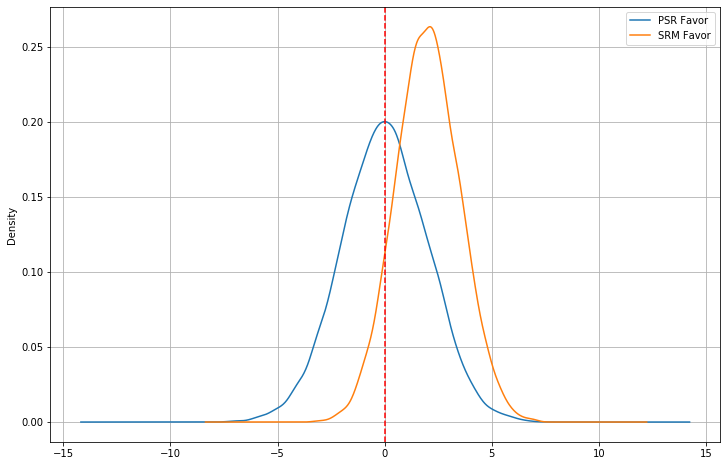

In [12]:
psr_favor = np.random.normal(0, 2, 10000)
strat_risk_favor = np.random.normal(2,1.5,10000)
df = pd.DataFrame({'PSR Favor': psr_favor, 'SRM Favor': strat_risk_favor})
df.plot(kind='kde', figsize=(12,8), grid=True)
plt.axvline(x=0,ls='--',c='r')
plt.show()